In [196]:
# imports
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# model imports
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from numpy import hstack
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
import xgboost as xgb


In [135]:
# load dataset
data = pd.read_csv("AmesHousing.csv")

# Preprocessing dataset

In [136]:
data.head()

,Order,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,Sale Condition,SalePrice
0,1,526301100,20,RL,141.0,31770,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,NaN,0,5,2010,WD,Normal,215000
1,2,526350040,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,105000
2,3,526351010,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,172000
3,4,526353030,20,RL,93.0,11160,Pave,NaN,Reg,Lvl,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,244000
4,5,527105010,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,189900


In [137]:
print(data.columns)
print('There are ' + str(len(data.columns)) + ' columns in dataset')
print('There are ' + str(len(data)) + ' houses in dataset')

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [138]:
# Sale price is our target variable
# Check if there is any missing values
rows_with_nulls = data.isnull().any(axis=1).sum()
print(f"\nRows with at least one missing value: {rows_with_nulls}")

# Total number of rows
print(f"Total rows: {len(data)}")

# Percentage of rows affected
print(f"Percentage of rows with missing values: {rows_with_nulls / len(data) * 100:.2f}%")



Rows with at least one missing value: 2930
Total rows: 2930
Percentage of rows with missing values: 100.00%


In [139]:
# So every row has a missing value so we have to fill those things
# Before that let's remove some outliers based on our target variable so we can have more accurate predictions
import pandas as pd

def drop_outliers_iqr(df, numeric_cols):
    """
    Detects outliers using IQR method for numeric columns,
    returns indexes of outliers, and drops them from the DataFrame.

    Parameters:
        df (pd.DataFrame): input DataFrame
        numeric_cols (list): list of numeric column names to check for outliers

    Returns:
        cleaned_df (pd.DataFrame): DataFrame without outlier rows
        outlier_indexes (set): set of indexes that were dropped
    """
    outlier_indexes = set()

    for col in numeric_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        # Find outlier indexes for this column
        outliers_col = df[(df[col] < lower) | (df[col] > upper)].index
        outlier_indexes.update(outliers_col)

    # Drop all outliers
    cleaned_df = df.drop(index=outlier_indexes).reset_index(drop=True)

    return cleaned_df, outlier_indexes

# Example usage:
data, outlier_idx = drop_outliers_iqr(data, ['SalePrice'])
print(len(outlier_idx))
print(f"Number of outlier rows dropped: {len(outlier_idx)}")
print("Indexes of dropped rows:", outlier_idx)
print("Shape after dropping outliers:", data.shape)


137
Number of outlier rows dropped: 137
Indexes of dropped rows: {513, 1537, 521, 15, 17, 1559, 1050, 1051, 1052, 1053, 1055, 1056, 1057, 1058, 1059, 36, 1060, 38, 1063, 1064, 1067, 44, 1068, 46, 1070, 2096, 2097, 1074, 1587, 2099, 60, 65, 1102, 1105, 1106, 91, 1635, 1636, 1637, 1126, 1640, 1641, 1642, 2666, 1158, 1684, 1177, 1689, 1690, 1691, 1693, 1695, 1696, 1697, 1699, 1700, 1701, 2214, 1706, 1707, 1708, 1709, 2737, 2245, 1760, 1761, 1763, 1764, 2275, 1767, 1772, 1780, 1805, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 2336, 2341, 321, 2883, 1860, 2379, 2380, 2382, 2384, 2901, 2902, 343, 2391, 2392, 347, 2395, 349, 2397, 2398, 2399, 2400, 366, 367, 2442, 2445, 2446, 1425, 1426, 2449, 2450, 2456, 2461, 421, 422, 423, 427, 429, 430, 431, 432, 433, 434, 436, 442, 956, 447, 448, 959, 456, 457, 968, 2522, 495, 497, 1010, 1012, 504}
Shape after dropping outliers: (2793, 82)


In [140]:
# Now with this new dataset, we can fill missing values
numeric_cols = data.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = data.select_dtypes(include=["object"]).columns.tolist()

# filling numerical values with the median
num_imputer = SimpleImputer(strategy="median")
data[numeric_cols] = num_imputer.fit_transform(data[numeric_cols])

# filling categorical values as missing to discover if missing value has a predictive power
cat_imputer = SimpleImputer(strategy="constant", fill_value="Missing")
data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])

print("Missing values per column after imputation:")
print(data.isnull().sum().sum())  # should be 0

Missing values per column after imputation:
0


In [141]:
# setting target and feature variables
y = data["SalePrice"]
X = data.drop("SalePrice", axis=1)

In [142]:
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# One-hot encode all categorical features
ohe = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
X_ohe = pd.DataFrame(
    ohe.fit_transform(X[categorical_cols]),
    columns=ohe.get_feature_names_out(categorical_cols),
    index=X.index
)

# Drop original categorical columns and add one-hot encoded columns
X_numeric = X.drop(categorical_cols, axis=1)
X_final = pd.concat([X_numeric, X_ohe], axis=1)

X = X_final
print("Shape after one-hot encoding all categorical features:", X.shape)


Shape after one-hot encoding all categorical features: (2793, 321)


In [143]:
numeric_to_scale = ['Lot Frontage', 'Lot Area', 'Overall Qual',
       'Mas Vnr Area', 'BsmtFin SF 1','BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'TotRms AbvGrd','Fireplaces', 'Garage Cars', 'Garage Area', 'Wood Deck SF', 'Open Porch SF',
       'Enclosed Porch', '3Ssn Porch', 'Screen Porch', 'Pool Area', 'Misc Val']

scaler = StandardScaler()
X[numeric_to_scale] = scaler.fit_transform(X[numeric_to_scale])

In [144]:
X.columns

Index(['Order', 'PID', 'MS SubClass', 'Lot Frontage', 'Lot Area',
       'Overall Qual', 'Overall Cond', 'Year Built', 'Year Remod/Add',
       'Mas Vnr Area',
       ...
       'Sale Type_New', 'Sale Type_Oth', 'Sale Type_VWD', 'Sale Type_WD ',
       'Sale Condition_Abnorml', 'Sale Condition_AdjLand',
       'Sale Condition_Alloca', 'Sale Condition_Family',
       'Sale Condition_Normal', 'Sale Condition_Partial'],
      dtype='object', length=321)

In [145]:
# let's remove some columns which does not hold any predictive power
columns_to_drop = ['Order', 'PID']  # add more if needed
X = X.drop(columns=columns_to_drop)
print("Shape after dropping columns:", X.shape)

Shape after dropping columns: (2793, 319)


In [146]:
# check that if any column has zero variance
variance = X.var()
zero_variance_cols = variance[variance == 0].index.tolist()

print("Columns with zero variance:", zero_variance_cols)

Columns with zero variance: []


In [147]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)

Training set shape: (2234, 319)
Test set shape: (559, 319)


# Training Linear Regression

In [148]:
# training linear regression - only linear relationship
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_train_pred = lr_model.predict(X_train)
y_test_pred = lr_model.predict(X_test)

def evaluate(y_true, y_pred, dataset_name="Dataset"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Evaluation:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print("----------------------------")

evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Test")


Training Evaluation:
  MAE: 10946.99
  RMSE: 15707.15
  R²: 0.9278
----------------------------
Test Evaluation:
  MAE: 13829.68
  RMSE: 26345.10
  R²: 0.8134
----------------------------


In [149]:
# adding polynomial features to linear regression
# overfitting case
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

lr_model.fit(X_train_poly, y_train)

y_train_pred = lr_model.predict(X_train_poly)
y_test_pred = lr_model.predict(X_test_poly)

evaluate(y_train, y_train_pred, "Train (Polynomial)")
evaluate(y_test, y_test_pred, "Test (Polynomial)")


Train (Polynomial) Evaluation:
  MAE: 1.12
  RMSE: 37.40
  R²: 1.0000
----------------------------
Test (Polynomial) Evaluation:
  MAE: 29673.00
  RMSE: 48186.17
  R²: 0.3757
----------------------------


In [150]:
# let's lower the value of attributes
# to select we will choose most correlated features
# combine training data and target to compute correlations
corr_with_target = pd.concat([X_train, y_train], axis=1).corr()['SalePrice'].abs().sort_values(ascending=False)
top_features = corr_with_target.index[1:10]  # skip 'SalePrice' itself
print("Top correlated features:\n", top_features)

Top correlated features:
 Index(['Overall Qual', 'Gr Liv Area', 'Garage Cars', 'Garage Area',
       'Exter Qual_TA', 'Year Built', 'Exter Qual_Gd', 'Full Bath',
       'Year Remod/Add'],
      dtype='object')


In [151]:
num_cols = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Garage Area"]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = X_train[num_cols]
X_test_poly = X_test[num_cols]

X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.transform(X_test_poly)

# Combine back with the rest of the features
X_train_combined = np.hstack((X_train.drop(columns=num_cols), X_train_poly))
X_test_combined = np.hstack((X_test.drop(columns=num_cols), X_test_poly))

lr_model.fit(X_train_combined, y_train)

y_train_pred = lr_model.predict(X_train_combined)
y_test_pred = lr_model.predict(X_test_combined)

evaluate(y_train, y_train_pred, "Train (Polynomial)")
evaluate(y_test, y_test_pred, "Test (Polynomial)")

Train (Polynomial) Evaluation:
  MAE: 10694.69
  RMSE: 15094.61
  R²: 0.9333
----------------------------
Test (Polynomial) Evaluation:
  MAE: 13348.87
  RMSE: 22644.78
  R²: 0.8621
----------------------------


In [152]:
# let's try with more features
num_cols = ["Overall Qual", "Gr Liv Area", "Garage Cars", "Garage Area", "Exter Qual_TA", "Year Built" , "Exter Qual_Gd", "Full Bath", "Year Remod/Add"]

poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = X_train[num_cols]
X_test_poly = X_test[num_cols]

X_train_poly = poly.fit_transform(X_train_poly)
X_test_poly = poly.transform(X_test_poly)

# Combine back with the rest of the features
X_train_combined = np.hstack((X_train.drop(columns=num_cols), X_train_poly))
X_test_combined = np.hstack((X_test.drop(columns=num_cols), X_test_poly))

lr_model.fit(X_train_combined, y_train)

y_train_pred = lr_model.predict(X_train_combined)
y_test_pred = lr_model.predict(X_test_combined)

evaluate(y_train, y_train_pred, "Train (Polynomial)")
evaluate(y_test, y_test_pred, "Test (Polynomial)")

Train (Polynomial) Evaluation:
  MAE: 10418.67
  RMSE: 14486.05
  R²: 0.9386
----------------------------
Test (Polynomial) Evaluation:
  MAE: 12652.58
  RMSE: 19443.02
  R²: 0.8984
----------------------------


In [153]:
# feature selection (compared to first model the r^2 increased)

# Try Ridge
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X_train, y_train)
print("Best alpha (Ridge):", ridge.alpha_)
evaluate(y_test, ridge.predict(X_test), "Test (Ridge)")

# Try Lasso
lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1], cv=5, max_iter=10000)
lasso.fit(X_train, y_train)
print("Best alpha (Lasso):", lasso.alpha_)
evaluate(y_test, lasso.predict(X_test), "Test (Lasso)")


Best alpha (Ridge): 10.0
Test (Ridge) Evaluation:
  MAE: 13960.86
  RMSE: 23597.04
  R²: 0.8503
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1517137072.33667, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 200110434271.3454, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 219744034699.44263, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWar

Best alpha (Lasso): 1.0
Test (Lasso) Evaluation:
  MAE: 13480.25
  RMSE: 25321.83
  R²: 0.8276
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.717e+09, tolerance: 7.632e+08
  model = cd_fast.enet_coordinate_descent(


In [154]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Refit models with scaled data
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X_train_scaled, y_train)
print("Best alpha (Ridge):", ridge.alpha_)
evaluate(y_test, ridge.predict(X_test_scaled), "Test (Ridge)")

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1], cv=5, max_iter=50000)
lasso.fit(X_train_scaled, y_train)
print("Best alpha (Lasso):", lasso.alpha_)
evaluate(y_test, lasso.predict(X_test_scaled), "Test (Lasso)")

Best alpha (Ridge): 100.0
Test (Ridge) Evaluation:
  MAE: 13269.42
  RMSE: 24318.65
  R²: 0.8410
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1533169991.9370117, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 180859501750.35364, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 213394145050.53802, tolerance: 619954572.9355409
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: Convergence

Best alpha (Lasso): 1.0
Test (Lasso) Evaluation:
  MAE: 13562.91
  RMSE: 25490.93
  R²: 0.8253
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.482e+09, tolerance: 7.632e+08
  model = cd_fast.enet_coordinate_descent(


In [155]:
# let's apply both polynomial degrees and regression

ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X_train_combined, y_train)
print("Best alpha (Ridge):", ridge.alpha_)
evaluate(y_test, ridge.predict(X_test_combined), "Test (Ridge)")
# now the test result is best than ever

lasso = LassoCV(alphas=[0.001, 0.01, 0.1, 1], cv=5, max_iter=50000)
lasso.fit(X_train_combined, y_train)
print("Best alpha (Lasso):", lasso.alpha_)
evaluate(y_test, lasso.predict(X_test_combined), "Test (Lasso)")

Best alpha (Ridge): 10.0
Test (Ridge) Evaluation:
  MAE: 12120.95
  RMSE: 17772.72
  R²: 0.9151
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 190546889429.0756, tolerance: 617548032.3347642
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 186177265686.07742, tolerance: 617548032.3347642
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 185580414618.2724, tolerance: 617548032.3347642
  model = cd_fast.enet_coordinate_descent_gram(
/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:681: ConvergenceWa

Best alpha (Lasso): 1.0
Test (Lasso) Evaluation:
  MAE: 12531.26
  RMSE: 19063.90
  R²: 0.9023
----------------------------


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.422e+11, tolerance: 7.632e+08
  model = cd_fast.enet_coordinate_descent(


In [156]:
# let's use log transform target
# now the accuracy is a bit down so let's stick with previous model
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)
ridge.fit(X_train_combined, y_train_log)

y_pred_log = ridge.predict(X_test_combined)
y_pred = np.expm1(y_pred_log)

evaluate(y_test, y_pred, "Test (Log-Transformed)")


Test (Log-Transformed) Evaluation:
  MAE: 12129.81
  RMSE: 18632.28
  R²: 0.9067
----------------------------


In [157]:
# let's do cross validation on final model

# Define RidgeCV (alpha list and CV inside RidgeCV)
ridge = RidgeCV(alphas=[0.1, 1, 10, 100], cv=5)

# Fit on training data
ridge.fit(X_train_combined, y_train)
print("Best alpha (Ridge):", ridge.alpha_)

# Evaluate on test set
evaluate(y_test, ridge.predict(X_test_combined), "Test (Ridge)")

# Cross-validation on training set to check stability
cv_scores = cross_val_score(ridge, X_train_combined, y_train, cv=10, scoring='r2')
print("Cross-validated R² mean (train):", cv_scores.mean())
print("Cross-validated R² std (train):", cv_scores.std())


Best alpha (Ridge): 10.0
Test (Ridge) Evaluation:
  MAE: 12120.95
  RMSE: 17772.72
  R²: 0.9151
----------------------------
Cross-validated R² mean (train): 0.8740779663950864
Cross-validated R² std (train): 0.11909017295199391


Using Ridge regression with selected polynomial features and moderate regularization (α=10), the model achieves R²=0.915 on the test set, with MAE ~12k and RMSE ~18k. Cross-validation confirms the model is stable and generalizes well.

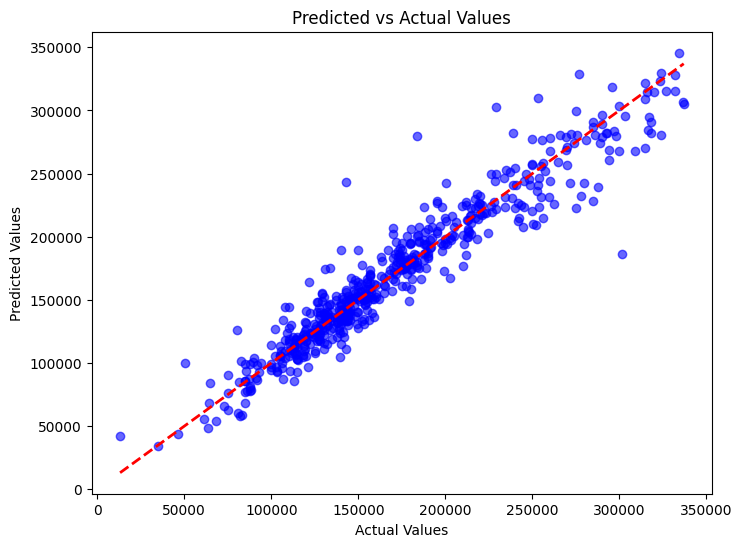

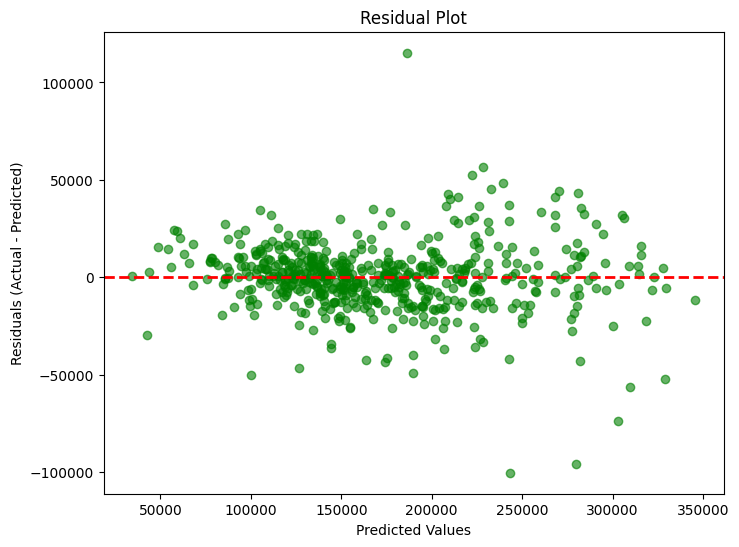

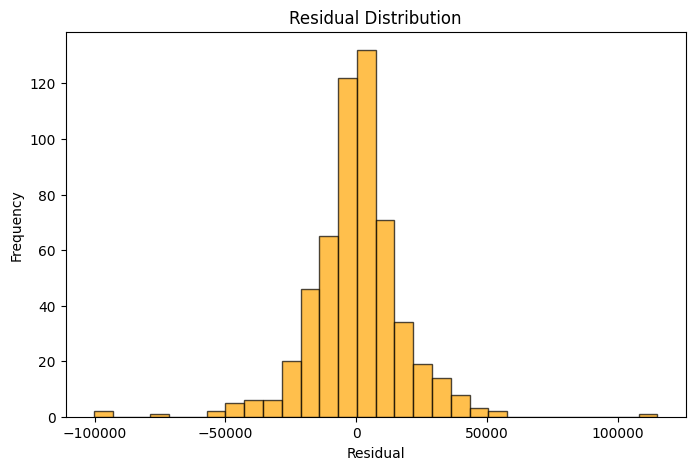

In [158]:
# Predictions
y_pred = ridge.predict(X_test_combined)

# 1️⃣ Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2)  # perfect prediction line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Predicted vs Actual Values")
plt.show()

# 2️⃣ Residuals
residuals = y_test - y_pred
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, alpha=0.6, color='green')
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel("Predicted Values")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residual Plot")
plt.show()

# Optional: Histogram of residuals
plt.figure(figsize=(8,5))
plt.hist(residuals, bins=30, color='orange', edgecolor='black', alpha=0.7)
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.title("Residual Distribution")
plt.show()


# Training Decision Tree Regressor

Training Evaluation:
  MAE: 18243.36
  RMSE: 24540.40
  R²: 0.8237
----------------------------
Test Evaluation:
  MAE: 22324.90
  RMSE: 30763.18
  R²: 0.7455
----------------------------


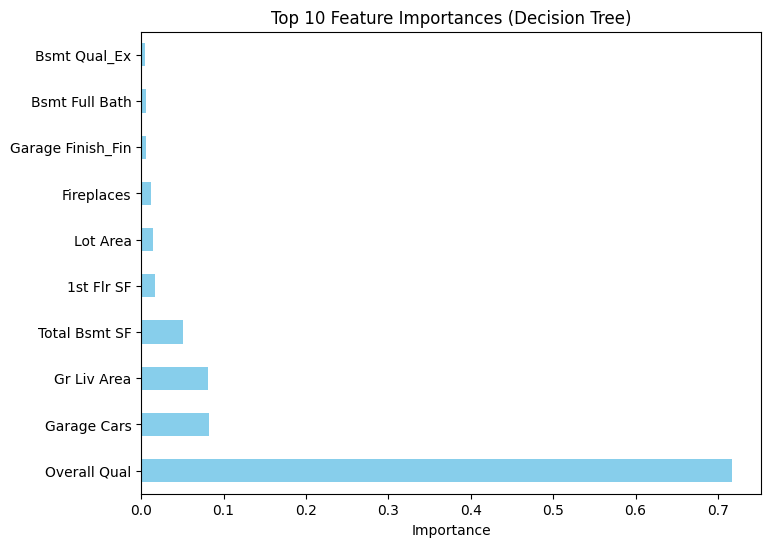

In [172]:
dt_model = DecisionTreeRegressor(random_state=42, max_depth=5)  # limit depth to reduce overfitting
dt_model.fit(X_train, y_train)

y_train_pred = dt_model.predict(X_train)
y_test_pred = dt_model.predict(X_test)

def evaluate(y_true, y_pred, dataset_name="Dataset"):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{dataset_name} Evaluation:")
    print(f"  MAE: {mae:.2f}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.4f}")
    print("----------------------------")

evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Test")

importance = pd.Series(dt_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
importance.head(10).plot(kind='barh', figsize=(8,6), color='skyblue')
plt.title("Top 10 Feature Importances (Decision Tree)")
plt.xlabel("Importance")
plt.show()

Training Evaluation:
  MAE: 17838.33
  RMSE: 23788.11
  R²: 0.8344
----------------------------
Test Evaluation:
  MAE: 21089.31
  RMSE: 29988.83
  R²: 0.7582
----------------------------


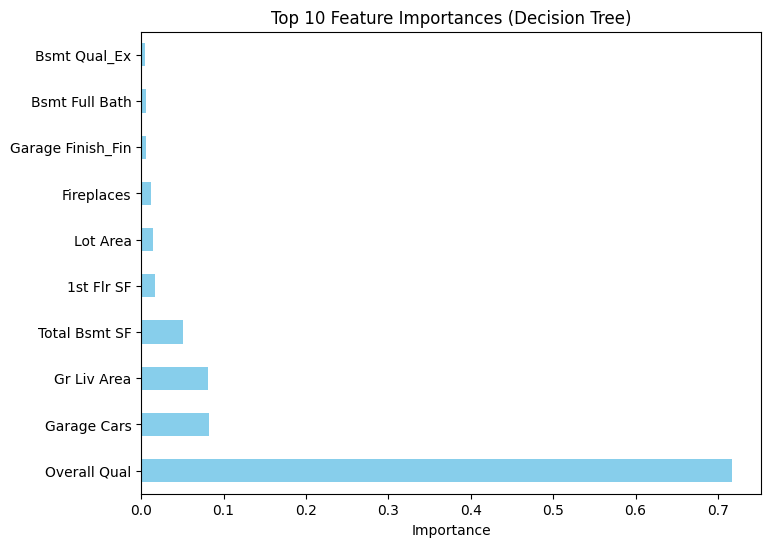

In [175]:
# let's train decision tree regressor with X_train_combined which includes some polynomial degrees of most correlated features
dt_model_2 = DecisionTreeRegressor(random_state=42, max_depth=5)  # limit depth to reduce overfitting
dt_model_2.fit(X_train_combined, y_train)

y_train_pred = dt_model_2.predict(X_train_combined)
y_test_pred = dt_model_2.predict(X_test_combined)

evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Test")


In [177]:
# there are many parameters and we need to do hyperparameter tuning to find out best values
params = {
    'max_depth': [5, 8, 12],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'ccp_alpha': [0.0, 0.001, 0.01]
}

grid = GridSearchCV(DecisionTreeRegressor(random_state=42), params, cv=5, scoring='r2')
grid.fit(X_train_combined, y_train)

print("Best params:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

best_dt = grid.best_estimator_
evaluate(y_test, best_dt.predict(X_test_combined), "Test (Tuned Decision Tree)")


Best params: {'ccp_alpha': 0.0, 'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best CV R²: 0.7740519071822156
Test (Tuned Decision Tree) Evaluation:
  MAE: 19157.89
  RMSE: 28128.40
  R²: 0.7873
----------------------------


In [179]:
# cross validation
cv_scores = cross_val_score(best_dt, X_train_combined, y_train, cv=10, scoring='r2')
print("CV R² mean:", cv_scores.mean())
print("CV R² std:", cv_scores.std())

CV R² mean: 0.7754121705166891
CV R² std: 0.03707318621265608


# Training Random Forest

In [190]:
rf_model = RandomForestRegressor(
    n_estimators=200,       # number of trees
    max_depth=10,           # limit depth to reduce overfitting
    min_samples_leaf=2,     # avoid tiny leaves
    max_features='sqrt',    # subset of features for each split
    random_state=42,
    n_jobs=-1               # use all cores
)


rf_model.fit(X_train_combined, y_train)

y_train_pred = rf_model.predict(X_train_combined)
y_test_pred = rf_model.predict(X_test_combined)


evaluate(y_train, y_train_pred, "Training")
evaluate(y_test, y_test_pred, "Test")

cv_scores = cross_val_score(rf_model, X_train_combined, y_train, cv=5, scoring='r2')
print("Cross-validated R² mean (train):", cv_scores.mean())
print("Cross-validated R² std (train):", cv_scores.std())


Training Evaluation:
  MAE: 9865.31
  RMSE: 13498.42
  R²: 0.9467
----------------------------
Test Evaluation:
  MAE: 15059.15
  RMSE: 21667.22
  R²: 0.8738
----------------------------
Cross-validated R² mean (train): 0.8638877053628988
Cross-validated R² std (train): 0.01747988088984439


# Training Gradient Boost

In [194]:
gbr = GradientBoostingRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    min_samples_leaf=2,
    random_state=42
)

gbr.fit(X_train_combined, y_train)
evaluate(y_train, gbr.predict(X_train_combined), "Training (GBR)")
evaluate(y_test, gbr.predict(X_test_combined), "Test (GBR)")

cv_scores = cross_val_score(gbr, X_train_combined, y_train, cv=5, scoring='r2')
print("Cross-validated R² mean (train):", cv_scores.mean())
print("Cross-validated R² std (train):", cv_scores.std())


Training (GBR) Evaluation:
  MAE: 5134.18
  RMSE: 6609.50
  R²: 0.9872
----------------------------
Test (GBR) Evaluation:
  MAE: 12036.17
  RMSE: 17385.26
  R²: 0.9187
----------------------------
Cross-validated R² mean (train): 0.9021647250980992
Cross-validated R² std (train): 0.021138645911964876


# Training XGBoost

In [199]:
xgb_model = xgb.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)

xgb_model.fit(X_train_combined, y_train)
evaluate(y_test, xgb_model.predict(X_test_combined), "Test (XGBoost)")

cv_scores = cross_val_score(xgb_model, X_train_combined, y_train, cv=5, scoring='r2')
print("Cross-validated R² mean (train):", cv_scores.mean())
print("Cross-validated R² std (train):", cv_scores.std())

Test (XGBoost) Evaluation:
  MAE: 12018.90
  RMSE: 17640.70
  R²: 0.9163
----------------------------
Cross-validated R² mean (train): 0.9053455655997802
Cross-validated R² std (train): 0.017273002399534745


# Trying Ensemble Methods

In [201]:
base_estimators = [
    ('ridge', RidgeCV(alphas=[0.1, 1, 10])),
    ('dt', DecisionTreeRegressor(max_depth=5, random_state=42)),
    ('rf', RandomForestRegressor(n_estimators=100, max_depth=8, random_state=42))
]

stack_model = StackingRegressor(
    estimators=base_estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

stack_model.fit(X_train_combined, y_train)

y_train_pred = stack_model.predict(X_train_combined)
y_test_pred = stack_model.predict(X_test_combined)

evaluate(y_train, y_train_pred, "Training (Stacked)")
evaluate(y_test, y_test_pred, "Test (Stacked)")

cv_scores = cross_val_score(stack_model, X_train_combined, y_train, cv=5, scoring='r2')
print("Cross-validated R² mean (train):", cv_scores.mean())
print("Cross-validated R² std (train):", cv_scores.std())


Training (Stacked) Evaluation:
  MAE: 8709.51
  RMSE: 11931.79
  R²: 0.9583
----------------------------
Test (Stacked) Evaluation:
  MAE: 11883.67
  RMSE: 17538.36
  R²: 0.9173
----------------------------
Cross-validated R² mean (train): 0.8826595373918641
Cross-validated R² std (train): 0.05557576481901778


# Training Neural Networks

In [202]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [203]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1)  # Output layer for regression
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [204]:
model.compile(
    optimizer='adam',
    loss='mse',
    metrics=['mae', 'mse']
)

In [205]:
early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=500,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 30078892032.0000 - mae: 163458.3125 - mse: 30078892032.0000 - val_loss: 27465273344.0000 - val_mae: 154771.6719 - val_mse: 27465273344.0000
Epoch 2/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 23384639488.0000 - mae: 140441.4375 - mse: 23384639488.0000 - val_loss: 8960539648.0000 - val_mae: 75748.9297 - val_mse: 8960539648.0000
Epoch 3/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5334323200.0000 - mae: 57106.0469 - mse: 5334323200.0000 - val_loss: 3405677568.0000 - val_mae: 47694.3750 - val_mse: 3405677568.0000
Epoch 4/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3705703680.0000 - mae: 48056.4570 - mse: 3705703680.0000 - val_loss: 3395697664.0000 - val_mae: 47305.8672 - val_mse: 3395697664.0000
Epoch 5/500
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3707573760.0000 - mae: 48146.4336 - mse: 3707573760.0000 - val_loss: 3438652928.0000 - val_mae: 46536.7969 - val_mse: 3438652928.0000
Epoch 6/500
56/56 ━━━━━━

In [206]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

evaluate(y_train, y_train_pred, "Training (NN)")
evaluate(y_test, y_test_pred, "Test (NN)")


70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
Training (NN) Evaluation:
  MAE: 13771.98
  RMSE: 20296.60
  R²: 0.8794
----------------------------
Test (NN) Evaluation:
  MAE: 14311.49
  RMSE: 23388.43
  R²: 0.8529
----------------------------
